# MD17: Ethanol (force field construction)
This tutorial demonstrates how to use E3x to construct a machine-learned force field. For this example, we use the MD17 dataset for ethanol. The code is written to be easy to adapt to datasets that contain multiple molecules of different size.

First, all necessary packages are imported.

In [1]:
import functools
import os
import urllib.request
import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# jax_ex

In [3]:
import jax
jax.default_backend()
jax.devices()


[cuda(id=0), cuda(id=1)]

In [4]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)


Next, we download the MD17 dataset for ethanol.

In [5]:
# Download the dataset.
filename = "md17_ethanol.npz"
if not os.path.exists(filename):
  print(f"Downloading {filename} (this may take a while)...")
  urllib.request.urlretrieve(f"http://www.quantum-machine.org/gdml/data/npz/{filename}", filename)

Now we write a small helper function to prepare train and validation datasets. Apart from choosing subsets of the full dataset and converting the data to a different format, this function also subtracts the mean energy of the training set from all data points. This is a useful numerical trick: The energy of a molecule is often a very large number (around $-97 000$ kcal/mol for ethanol), but the relative energy between different conformations of the same molecule is usually much smaller (a few kcal/mol for ethanol). Since models are typically trained with single precision floats for efficiency, the large energy offset wastes precious numerical precision. For this reason, large offsets should be subtracted frow the raw data (typically stored in double precision) *before* converting to single precision. Note that subtracting arbitrary constants from the energy does not change physics (of course, the constant can also just be added back to the model predictions after training).

In [14]:
def prepare_datasets(key, num_train, num_valid):
  # Load the dataset.
  dataset = np.load(filename)

  # Make sure that the dataset contains enough entries.
  num_data = len(dataset['E'])
  num_draw = num_train + num_valid
  if num_draw > num_data:
    raise RuntimeError(
      f'datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}')

  # Randomly draw train and validation sets from dataset.
  choice = np.asarray(jax.random.choice(key, num_data, shape=(num_draw,), replace=False))
  train_choice = choice[:num_train]
  valid_choice = choice[num_train:]

  # Determine mean energy of the training set.
  mean_energy = np.mean(dataset['E'][train_choice])  # ~ -97000

  # Collect and return train and validation sets.
  train_data = dict(
    energy=jnp.asarray(dataset['E'][train_choice, 0] - mean_energy),
    forces=jnp.asarray(dataset['F'][train_choice]),
    atomic_numbers=jnp.asarray(dataset['z']),
    positions=jnp.asarray(dataset['R'][train_choice]),
  )
  valid_data = dict(
    energy=jnp.asarray(dataset['E'][valid_choice, 0] - mean_energy),
    forces=jnp.asarray(dataset['F'][valid_choice]),
    atomic_numbers=jnp.asarray(dataset['z']),
    positions=jnp.asarray(dataset['R'][valid_choice]),
  )
  return train_data, valid_data, mean_energy

Next, we define a very simple message-passing neural network. 

Let's first describe the model inputs and outputs: Our model takes `atomic_numbers` of shape `(num_atoms,)` (encoding the atom types), `positions` of shape `(num_atoms, 3)`, and index lists `dst_idx` (destination index) and `src_idx` (source index), both of shape `(num_pairs,)`, as inputs. The `dst_idx` and `src_idx` index lists specify "which atoms talk with each other" during a message-pass. For example, for a molecule with three atoms, these index lists could be `dst_idx = [0, 0, 1, 1, 2, 2]` and `src_idx = [1, 2, 0, 2, 0, 1]`. This would mean that the "destination atom" at index 0 receives messages from the "source atoms" at indices 1 and 2, and so on. This input format allows the model to handle batches of molecules with different numbers of atoms *without needing any padding* (in this example, all molecules are ethanol, so this is not necessary, but it's useful in general for more complicated tasks). We simply concatenate the `atomic_numbers` and `positions` of all molecules in the batch (as if they were one big molecule) and specify the index lists such that atoms in different molecules of the batch do not "talk to each other". The only additional information we need is a structure `batch_segments` that tells the model which atoms belong to which molecule in the batch and the total `batch_size`. For example, a batch consisting of a H$_2$O and a N$_2$ molecule could be specified with `atomic_numbers = [1, 1, 8, 7, 7]`, `dst_idx = [0, 0, 1, 1, 2, 2, 3, 4]`, `src_idx = [1, 2, 0, 2, 0, 1, 4, 3]`, `batch_segments = [0, 0, 0, 1, 1]` (meaning the first three atoms belong to molecule `0`, the last two to molecule `1`), and `batch_size = 2`. The outputs of our model are the `energy` of shape `(batch_size,)` of every molecule in the batch and the `forces` of shape `(num_atoms, 3)` acting on each atom.

Since `forces` are the negative gradient of the `energy` with respect to the atomic `positions`, the model only needs to predict `energy`, as `forces` can be derived with automatic differentiation. This has the additional advantage that the forces will be conservative, i.e. they will respect the physical principle of energy conservation. The energy prediction comprises the following steps:

1. Calculate the displacement vectors $\vec{r}_{ij}=\vec{r}_{j}-\vec{r}_{i}$, where $\vec{r}_{i}$ and $\vec{r}_{j}$ are the positions of atoms $i$ (destination) and $j$ (source), for all pairs $i,j$ specified by the index lists.

2. Expand the displacement vectors in radial-spherical basis functions to featurize them. Note that the basis functions use a cutoff, so that they go to zero beyond a certain distance.

3. Embed the atoms in feature space by assigning them to learnable embeddings (one for each element).

4. Perform `num_iterations` feature refinements. Each iteration performs a message-pass and combines the message with the current features of each atom. These intermediate features are passed through an atom-wise two-layer MLP and added to the original features (residual connection).

5. Predict atomic energy contributions by performing linear regression on the final (scalar) features of each atom. Each atom type/element has its own bias term.

6. Sum the atomic energy contributions within each batch segment to obtain the energy for every molecule in the batch.

In [7]:
class MessagePassingModel(nn.Module):
  features: int = 32
  max_degree: int = 2
  num_iterations: int = 3
  num_basis_functions: int = 8
  cutoff: float = 5.0
  max_atomic_number: int = 118  # This is overkill for most applications.


  def energy(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
        # features for efficiency reasons.
        y = e3x.nn.MessagePass(max_degree=0, include_pseudotensors=False)(x, basis, dst_idx=dst_idx, src_idx=src_idx)
        # After the final message pass, we can safely throw away all non-scalar features.
        x = e3x.nn.change_max_degree_or_type(x, max_degree=0, include_pseudotensors=False)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
      y = e3x.nn.add(x, y)

      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

      # Residual connection.
      x = e3x.nn.add(x, y)

    # 5. Predict atomic energies with an ordinary dense layer.
    element_bias = self.param('element_bias', lambda rng, shape: jnp.zeros(shape), (self.max_atomic_number+1))
    atomic_energies = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)  # (..., Natoms, 1, 1, 1)
    atomic_energies = jnp.squeeze(atomic_energies, axis=(-1, -2, -3))  # Squeeze last 3 dimensions.
    atomic_energies += element_bias[atomic_numbers]

    # 6. Sum atomic energies to obtain the total energy.
    energy = jax.ops.segment_sum(atomic_energies, segment_ids=batch_segments, num_segments=batch_size)

    # To be able to efficiently compute forces, our model should return a single output (instead of one for each
    # molecule in the batch). Fortunately, since all atomic contributions only influence the energy in their own
    # batch segment, we can simply sum the energy of all molecules in the batch to obtain a single proxy output
    # to differentiate.
    return -jnp.sum(energy), energy  # Forces are the negative gradient, hence the minus sign.


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
    # jax.value_and_grad to create a function for predicting both energy and forces for us.
    energy_and_forces = jax.value_and_grad(self.energy, argnums=1, has_aux=True)
    (_, energy), forces = energy_and_forces(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

    return energy, forces

With our model in place, we now write a function to prepare a batch of molecules in the format described above. For this simple example, the source and destination index lists include all $N(N-1)$ pairwise combinations of $N$ atoms (without self-interactions). E3x contains helper functions, such as `sparse_pairwise_indices`, to construct such $O(N^2)$ index lists. This is fine for a small molecule like ethanol, but we can do better than $O(N^2)$ scaling, which becomes important for larger molecules. Recall that our message-passing model uses a cutoff when expanding displacement vectors in basis functions. While it doesn't hurt to include interactions beyond the cutoff in the index lists (they will simply contribute nothing to the message received by the destination atom), it is not very efficient to do so. In a real application, it would be better to construct the index lists using some spatial partitioning method, such that only interactions within the cutoff distance are included. With this trick, evaluating the message-passing model scales $O(NM)$, where $M \ll N$ is the average number of atoms within the cutoff distance.

In [8]:
def prepare_batches(key, data, batch_size):
  # Determine the number of training steps per epoch.
  data_size = len(data['energy'])
  steps_per_epoch = data_size//batch_size

  # Draw random permutations for fetching batches from the train data.
  perms = jax.random.permutation(key, data_size)
  perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
  perms = perms.reshape((steps_per_epoch, batch_size))

  # Prepare entries that are identical for each batch.
  num_atoms = len(data['atomic_numbers'])
  batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
  atomic_numbers = jnp.tile(data['atomic_numbers'], batch_size)
  offsets = jnp.arange(batch_size) * num_atoms
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
  dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
  src_idx = (src_idx + offsets[:, None]).reshape(-1)

  # Assemble and return batches.
  return [
    dict(
        energy=data['energy'][perm],
        forces=data['forces'][perm].reshape(-1, 3),
        atomic_numbers=atomic_numbers,
        positions=data['positions'][perm].reshape(-1, 3),
        dst_idx=dst_idx,
        src_idx=src_idx,
        batch_segments = batch_segments,
    )
    for perm in perms
  ]

Next, we define our loss function. As is common for regression tasks, we choose the $L_2$ (squared error) loss. Since we want to fit two different quantities at once (energy and forces), we simply add their respective losses together. We also add a weighting factor that allows us to tune the relative importance of the different loss terms. For convenience, we also define a function to compute the mean absolute errors, for keeping track of the model performance during training.

In [9]:
def mean_squared_loss(energy_prediction, energy_target, forces_prediction, forces_target, forces_weight):
  energy_loss = jnp.mean(optax.l2_loss(energy_prediction, energy_target))
  forces_loss = jnp.mean(optax.l2_loss(forces_prediction, forces_target))
  return energy_loss + forces_weight * forces_loss

def mean_absolute_error(prediction, target):
  return jnp.mean(jnp.abs(prediction - target))

Now that we have all the ingredients, we need to write some boilerplate for training models.

In [10]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, forces_weight, opt_state, params):
  def loss_fn(params):
    energy, forces = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      energy_prediction=energy,
      energy_target=batch['energy'],
      forces_prediction=forces,
      forces_target=batch['forces'],
      forces_weight=forces_weight
    )
    return loss, (energy, forces)
  (loss, (energy, forces)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  energy_mae = mean_absolute_error(energy, batch['energy'])
  forces_mae = mean_absolute_error(forces, batch['forces'])
  return params, opt_state, loss, energy_mae, forces_mae


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, forces_weight, params):
  energy, forces = model_apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
  )
  loss = mean_squared_loss(
    energy_prediction=energy,
    energy_target=batch['energy'],
    forces_prediction=forces,
    forces_target=batch['forces'],
    forces_weight=forces_weight
  )
  energy_mae = mean_absolute_error(energy, batch['energy'])
  forces_mae = mean_absolute_error(forces, batch['forces'])
  return loss, energy_mae, forces_mae


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, forces_weight, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers']))
  params = model.init(init_key,
    atomic_numbers=train_data['atomic_numbers'],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  opt_state = optimizer.init(params)

  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size)

    # Loop over train batches.
    train_loss = 0.0
    train_energy_mae = 0.0
    train_forces_mae = 0.0
    for i, batch in enumerate(train_batches):
      params, opt_state, loss, energy_mae, forces_mae = train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        forces_weight=forces_weight,
        opt_state=opt_state,
        params=params
      )
      train_loss += (loss - train_loss)/(i+1)
      train_energy_mae += (energy_mae - train_energy_mae)/(i+1)
      train_forces_mae += (forces_mae - train_forces_mae)/(i+1)

    # Evaluate on validation set.
    valid_loss = 0.0
    valid_energy_mae = 0.0
    valid_forces_mae = 0.0
    for i, batch in enumerate(valid_batches):
      loss, energy_mae, forces_mae = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        forces_weight=forces_weight,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)
      valid_energy_mae += (energy_mae - valid_energy_mae)/(i+1)
      valid_forces_mae += (forces_mae - valid_forces_mae)/(i+1)

    # Print progress.
    print(f"epoch: {epoch: 3d}                    train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3f} {valid_loss : 8.3f}")
    print(f"    energy mae [kcal/mol]   {train_energy_mae: 8.3f} {valid_energy_mae: 8.3f}")
    print(f"    forces mae [kcal/mol/Å] {train_forces_mae: 8.3f} {valid_forces_mae: 8.3f}")


  # Return final model parameters.
  return params

The last step before training the model is to define the hyperparamters.

In [11]:
# Model hyperparameters.
features = 32
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 5.0

# Training hyperparameters.
num_train = 900
num_valid = 100
num_epochs = 100
learning_rate = 0.01
forces_weight = 1.0
batch_size = 10

In [12]:
jax.default_backend()
jax.devices()


[cuda(id=0), cuda(id=1)]

Finally, we can train our model.

In [15]:
# Create PRNGKeys.
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)

# Draw training and validation sets.
train_data, valid_data, _ = prepare_datasets(data_key, num_train=num_train, num_valid=num_valid)



In [16]:
train_data["atomic_numbers"]

Array([6, 6, 8, 1, 1, 1, 1, 1, 1], dtype=uint8)

Even a very simple model can achieve energy prediction errors well below 1 kcal/mol ("chemical accuracy") after training for a hundred epochs (the model is not converged yet, but it's good enough for now).

Once the model is trained, we can use it as a force field, e.g. to do structure optimization, or to run molecular dynamics simulations. To demonstrate this, we use the atomic simulation environment (ASE) and py3Dmol (for visualization), so a few additional imports are necessary.

In [35]:
# params

In [36]:
type(params)

dict

In [40]:
import pickle
# open a file, where you ant to store the data
with open('params.pkl', 'wb') as file:
    pickle.dump(params, file)

In [41]:
import pandas as pd
params = pd.read_pickle("params.pkl")

In [42]:
message_passing_model

MessagePassingModel(
    # attributes
    features = 32
    max_degree = 2
    num_iterations = 3
    num_basis_functions = 16
    cutoff = 5.0
    max_atomic_number = 118
)

In [43]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

Before we can use our model as a `Calculator` in ASE, we need to write a small interface. The following implementation is very bare bones, but it does the trick for a few simple demonstrations.

In [44]:
@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return message_passing_model.apply(params, 
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(), 
      positions=atoms.get_positions(), 
      dst_idx=dst_idx, 
      src_idx=src_idx
    )
    self.results['energy'] = energy * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces * ase.units.kcal/ase.units.mol

At first, let's find an optimized structure for ethanol. We arbitrarily initialize the structure to some entry in our training data and then use ASE's `BFGS` optimizer to optimize it.

In [45]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(train_data['atomic_numbers'], train_data['positions'][0])
atoms.set_calculator(MessagePassingCalculator())

# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.0005)

      Step     Time          Energy         fmax
BFGS:    0 18:49:15        0.029741        2.9831
BFGS:    1 18:49:15       -0.258419        1.6295
BFGS:    2 18:49:15       -0.397053        1.4298
BFGS:    3 18:49:15       -0.460368        0.9320
BFGS:    4 18:49:15       -0.493666        0.4323
BFGS:    5 18:49:15       -0.508681        0.3789
BFGS:    6 18:49:15       -0.532095        0.4464
BFGS:    7 18:49:15       -0.541544        0.2659
BFGS:    8 18:49:15       -0.547377        0.2170
BFGS:    9 18:49:15       -0.551952        0.2387
BFGS:   10 18:49:15       -0.556474        0.2502
BFGS:   11 18:49:15       -0.559787        0.1899
BFGS:   12 18:49:15       -0.561795        0.1261
BFGS:   13 18:49:15       -0.563219        0.1216
BFGS:   14 18:49:15       -0.564579        0.0993
BFGS:   15 18:49:15       -0.565670        0.0918
BFGS:   16 18:49:15       -0.566521        0.1026
BFGS:   17 18:49:15       -0.567514        0.1318
BFGS:   18 18:49:15       -0.569197        0.1607
B

A promising start! Note that ASE uses electron volts (eV) as energy units, so the final structure has an energy that is lower by roughly 0.6 eV, or about 14 kcal/mol. Let's check how the optimized structure looks.

In [46]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's try to run a molecular dynamics simulation. We draw initial momenta from a Maxwell-Boltzmann distribution at 300 K, remove center of mass translation and rotation, and then use Verlet integration to integrate the equations of motion for 2000 steps using a timestep of 0.5 fs. For visualization purposes, we also save each frame and keep track of potential, kinetic, and total energies.

In [48]:
# Parameters.
temperature = 300
timestep_fs = 0.5
num_steps = 500

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.  
  integrator.run(1)  
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

/tmp/ipykernel_1037/235484555.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  potential_energy[i] = atoms.get_potential_energy()
/tmp/ipykernel_1037/235484555.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  total_energy[i] = atoms.get_total_energy()


step     0 epot  0.407 ekin  0.323 etot  0.730
step   100 epot  0.076 ekin  0.651 etot  0.727
step   200 epot  0.300 ekin  0.426 etot  0.726
step   300 epot -0.049 ekin  0.774 etot  0.725
step   400 epot  0.090 ekin  0.636 etot  0.726


Let's have a look at the trajectory.

In [49]:
view.getModel().setCoordinates(frames, 'array')
view.animate({'loop': 'forward', 'interval': 0.1})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This looks reasonable. As a final check, let's plot the potential, kinetic, and total energies.

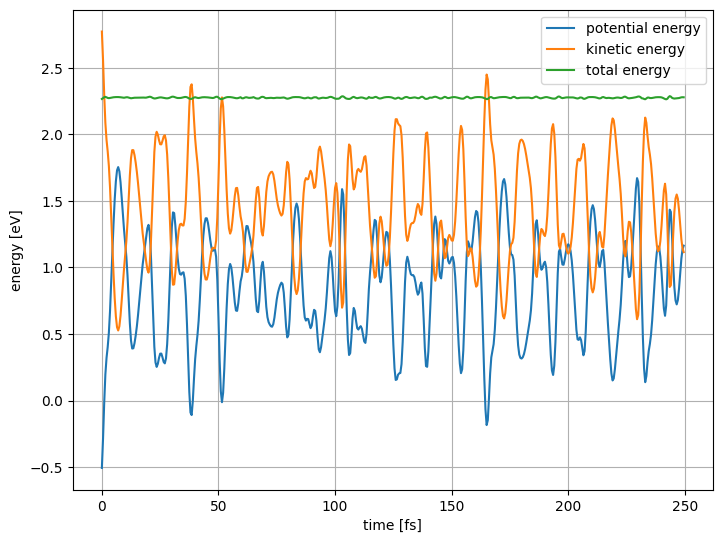

In [30]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

(array([  5.,  21.,  39.,  78.,  94., 103.,  89.,  56.,  11.,   4.]),
 array([-1.20423474e-02, -9.65153360e-03, -7.26071978e-03, -4.86990595e-03,
        -2.47909212e-03, -8.82782936e-05,  2.30253553e-03,  4.69334936e-03,
         7.08416319e-03,  9.47497702e-03,  1.18657908e-02]),
 <BarContainer object of 10 artists>)

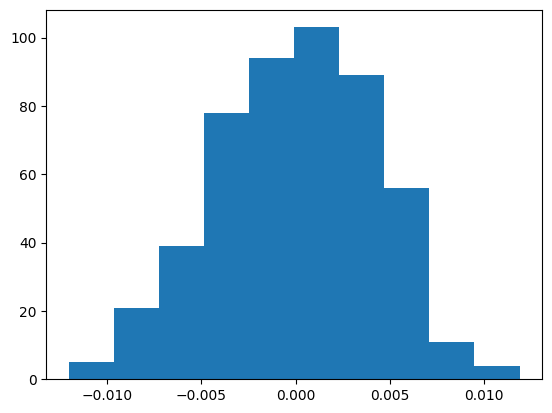

In [31]:
%matplotlib inline
plt.hist(total_energy - total_energy.mean())

As expected, the potential and kinetic energies fluctuate during the trajectory. However, their sum, the total energy, is constant, as it should be (energy conservation). Tiny deviations in the total energy stem primarily from inaccuracies in the Velocity Verlet integration and can be reduced by choosing a smaller timestep.